In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [9]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

channel = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/channel_autocorr.npy')
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

In [24]:
# function to compute autocorrelation function - this version removes mean at the beginning
def autocorr_func_0mean(X0, lon, lat, rmax, dr):
    idx0 = int(lon.shape[1]/2)
    idy0 = int(lon.shape[0]/2)
    lon0 = lon[idy0,idx0]
    lat0 = lat[idy0,idx0]

    distance = gm.great_circle(lon0, lat0, lon, lat)
   
    radius = np.arange(0,rmax,dr)
    A = np.zeros(len(radius)+1)
    R = np.zeros(len(radius)+1)

    X = X0 - np.nanmean(X0)     # removing mean value

    A[0] = np.nanmean( X*X )
    R[0] = 0

    for jr,r in enumerate(radius):
        id_r = (distance>r)&(distance<r+dr)
       
        all_valid_couples = np.transpose(np.nonzero(id_r))
        all_valid_couples = all_valid_couples[all_valid_couples[:,0] >= idy0 ]

        shift_couples = all_valid_couples.copy()
        shift_couples[:,0] = idy0 - shift_couples[:,0]
        shift_couples[:,1] = idx0 - shift_couples[:,1]
        scra = []
        for shift in shift_couples:
            Xm = X.copy()
            Xs = np.roll(X, shift, axis=(0,1))
            Xs[shift[0]:,:] = np.nan
            Xm[shift[0]:,:] = np.nan
            if shift[1] < 0:
                Xs[:,shift[1]:] = np.nan
                Xm[:,shift[1]:] = np.nan
            if shift[1] > 0:
                Xs[:,:shift[1]] = np.nan
                Xm[:,:shift[1]] = np.nan
            scra.append(np.nanmean( Xm*Xs ))
        A[jr+1] = np.nanmean(scra)
        R[jr+1] = r+dr
    A = A/A[0]
    return A,R

In [6]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

# lat and lon
lon = ds_hourly['nav_lon'].values
lat = ds_hourly['nav_lat'].values

In [21]:
idx0 = int(350) #int(lon.shape[1]/2)
idy0 = int(350) #int(lon.shape[0]/2)
lon0 = lon[idy0,idx0]
lat0 = lat[idy0,idx0]

distance = gm.great_circle(lon0, lat0, lon, lat)

In [22]:
idx0

350

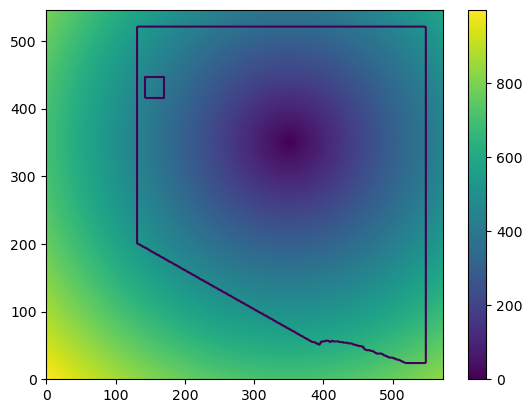

In [23]:
a  = plt.pcolormesh(distance)
plt.contour(sea_mask_modified, [0])
plt.colorbar(a)

### autocorrelation of SST

In [10]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values; 

In [14]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask_modified, drop=False).values

In [27]:
rmax, dr = 200, 5

autocorr_sst, radius_sst = autocorr_func_0mean(sst_day[0], lon, lat, rmax, dr)

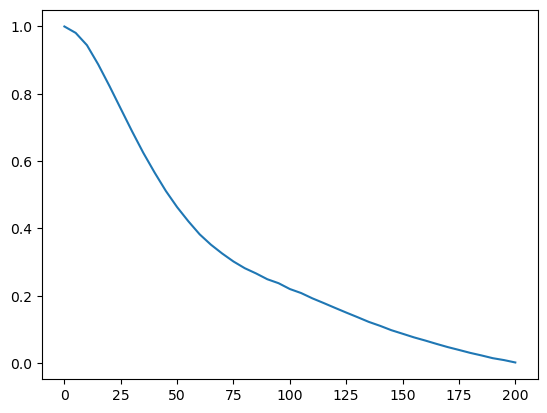

In [28]:
plt.plot(radius_sst, autocorr_sst)

In [17]:
ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day']*sea_mask_modified_nan

In [18]:
rmax, dr = 200, 5

autocorr_dsst, radius_dsst = autocorr_func_0mean(dsst_day[0]*channel, lon, lat, rmax, dr)

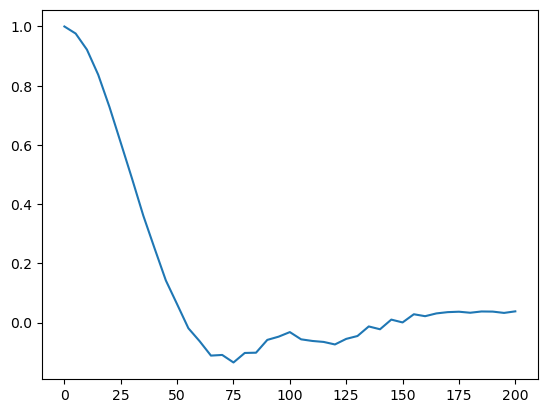

In [19]:
plt.plot(radius_dsst, autocorr_dsst)

### autocorrelation of LHF

In [7]:
LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
LH = LH.where(sea_mask_modified, drop=False).values; 

In [14]:
rmax, dr = 200, 5

autocorr_lh, radius_lh = autocorr_func_0mean(LH[10], lon, lat, rmax, dr)

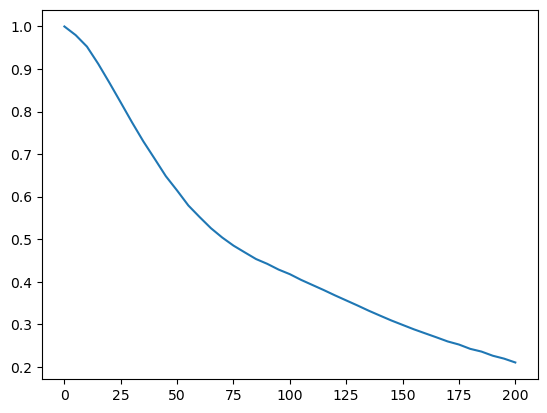

In [15]:
plt.plot(radius_lh, autocorr_lh)

In [8]:
s = 100

dLH, LH_smooth = np.zeros(LH.shape), np.zeros(LH.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_smooth[t] = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_smooth[t]

0
10
20


### autcorr for smoothed variables

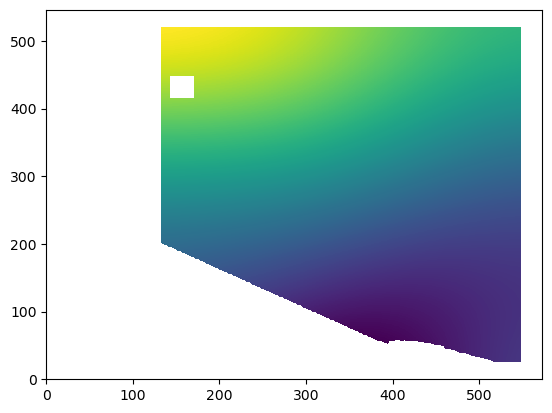

In [11]:
plt.pcolormesh(LH_smooth[10])

In [12]:
rmax, dr = 400, 20

autocorr_lh_smooth, radius_lh_smooth = autocorr_func_0mean(LH_smooth[0], lon, lat, rmax, dr)

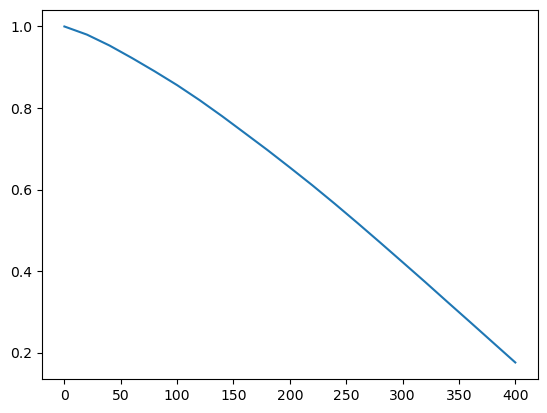

In [13]:
plt.plot(radius_lh_smooth, autocorr_lh_smooth)

### autocorrelation of qvapor levels

In [26]:
# load data
QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR = QVAPOR['QVAPOR'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
QVAPOR_day = QVAPOR.groupby('time_counter.day').mean()
QVAPOR_day = QVAPOR_day.where(sea_mask_modified, drop=False)
QVAPOR_day = QVAPOR_day.values*1000

In [41]:
rmax, dr = 200, 5

autocorr_qv, radius_qv = autocorr_func_0mean(QVAPOR_day[10,2,:,:], lon, lat, rmax, dr)

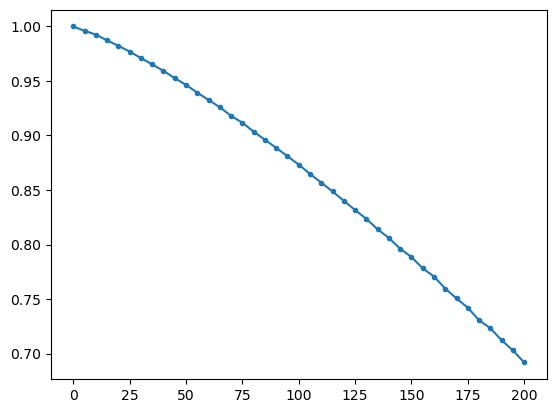

In [43]:
plt.plot(radius_qv, autocorr_qv, '.-')

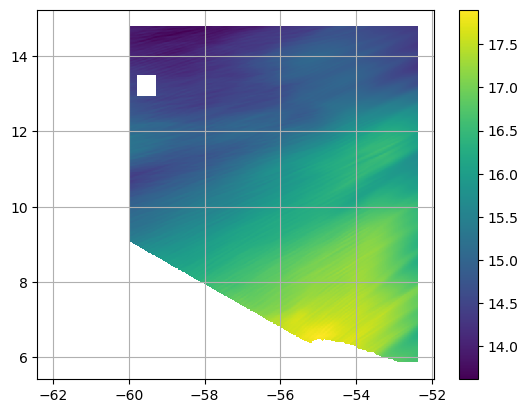

In [45]:
plt.pcolormesh(lon,lat,QVAPOR_day[10,2])
plt.colorbar()
plt.grid()

In [53]:
dq = np.zeros_like(QVAPOR_day[10,2])

s = 50
# upscale using gaussian filter
q = gm.nan_gaussian_filter(QVAPOR_day[10,2],s)                             
dq = QVAPOR_day[10,2] - q

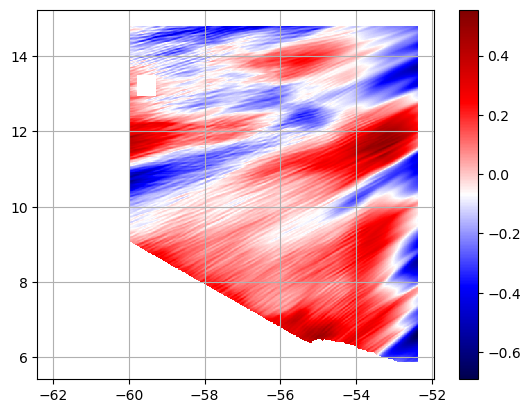

In [54]:
plt.pcolormesh(lon,lat,dq, cmap='seismic')
plt.colorbar()
plt.grid()

In [55]:
#############    THERMODYNAMIC CONTRIBUTION TO dLH/dSST?

q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day.where(sea_mask_modified, drop=False).values;

In [56]:
rmax, dr = 200, 5

autocorr_qv, radius_qv = autocorr_func_0mean(q2_day[2,:,:], lon, lat, rmax, dr)

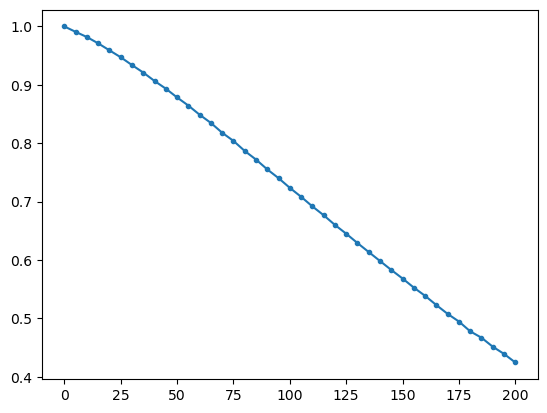

In [57]:
plt.plot(radius_qv, autocorr_qv, '.-')

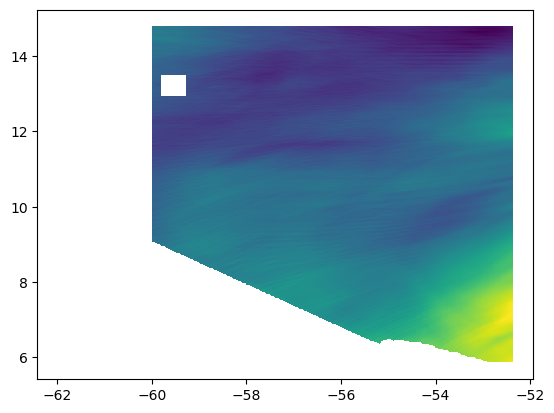

In [58]:
plt.pcolormesh(lon,lat,q2_day[2])

In [ ]:
### autocorrelation of potential temperature

In [ ]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask_modified, drop=False)
# pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300. 

pot_temp_full = pot_temp+T0